# Redes Neuronales Convolucionales (CNN)

## Proyecto 1: Detección de números escritos a mano

**Tabla de contenidos**   
1. [Importar librerias](#importar-librerías)
2. [Carga y preparacion del set de datos MNIST](#carga-y-preparación-del-set-de-datos-mnist)
3. [Codificacion y normalizacion de los datos](#codificación-y-normalización-de-los-datos)
4. [Aumento de datos (Data Augmentation)](#aumento-de-datos-data-augmentation)
5. [Creacion del modelo y compilacion](#creación-del-modelo-y-compilación)
6. [Entrenamiento de la red neuronal](#entrenamiento-de-la-red-neuronal)
7. [Graficos](#gráficos)
8. [Guardar modelo entrenado](#guardar-modelo-entrenado)

### Importar librerias

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Carga y preparacion del set de datos MNIST

El conjunto de datos MNIST contiene imágenes en escala de grises de 28x28 píxeles. Las capas de convolución en Keras/TensorFlow esperan que los datos de entrada tengan la forma ``(número de muestras, altura, anchura, canales)``. En el caso de imágenes en escala de grises, el número de canales es 1 (a diferencia de las imágenes a color que tienen 3 canales: RGB).

In [2]:
#Cargar los datos de MNIST

(X_entrenamiento, Y_entrenamiento), (X_pruebas, Y_pruebas) = mnist.load_data()

#Colocar los datos en la forma correcta (1, 28, 28, 1)
X_entrenamiento = X_entrenamiento.reshape(X_entrenamiento.shape[0], 28, 28, 1) # número de muestras, altura, anchura, canales
X_pruebas = X_pruebas.reshape(X_pruebas.shape[0], 28, 28, 1)

### Codificacion y normalizacion de los datos

In [3]:
#Hacer 'one-hot encoding' de los resultados 
#NOTA: Cuando usamos una capa de salida softmax y categorical_crossentropy como función de pérdida, hay que trabajar con etiquetas codificadas
Y_entrenamiento = to_categorical(Y_entrenamiento)
Y_pruebas = to_categorical(Y_pruebas)

#Convertir a flotante y normalizar para que aprenda mejor la red
X_entrenamiento = X_entrenamiento.astype('float32') / 255
X_pruebas = X_pruebas.astype('float32') / 255

### Aumento de datos (Data Augmentation)

Técnica que se utiliza para aumentar la cantidad de datos de entrenamiento, generando imágenes más variadas (rotaciones, cambios de posición, tamaño, etc). Esto ayuda a que la red sea más robusta, ya que evita que el modelo memorice en el entrenamiento.

In [4]:
# DATA AUGMENTATION

rango_rotacion = 30
mov_ancho = 0.25
mov_alto = 0.25
#rango_inclinacion=15 #No uso este de momento 
rango_acercamiento=[0.5,1.5] # Rango para zoom aleatorio. Se especifica que el zoom puede ser desde el 50 % al 150 % del tamaño original

# ImageDataGenerator de keras permite aplicar las transformaciones especificadas en las imágenes de entrenamiento de manera aleatoria
datagen = ImageDataGenerator( 
    rotation_range = rango_rotacion,
    width_shift_range = mov_ancho,
    height_shift_range = mov_alto,
    zoom_range=rango_acercamiento,
    #shear_range=rango_inclinacion #No uso este de momento
)

# Ajustar el Generador de Datos a los Datos de Entrenamiento
datagen.fit(X_entrenamiento)

ANTES:



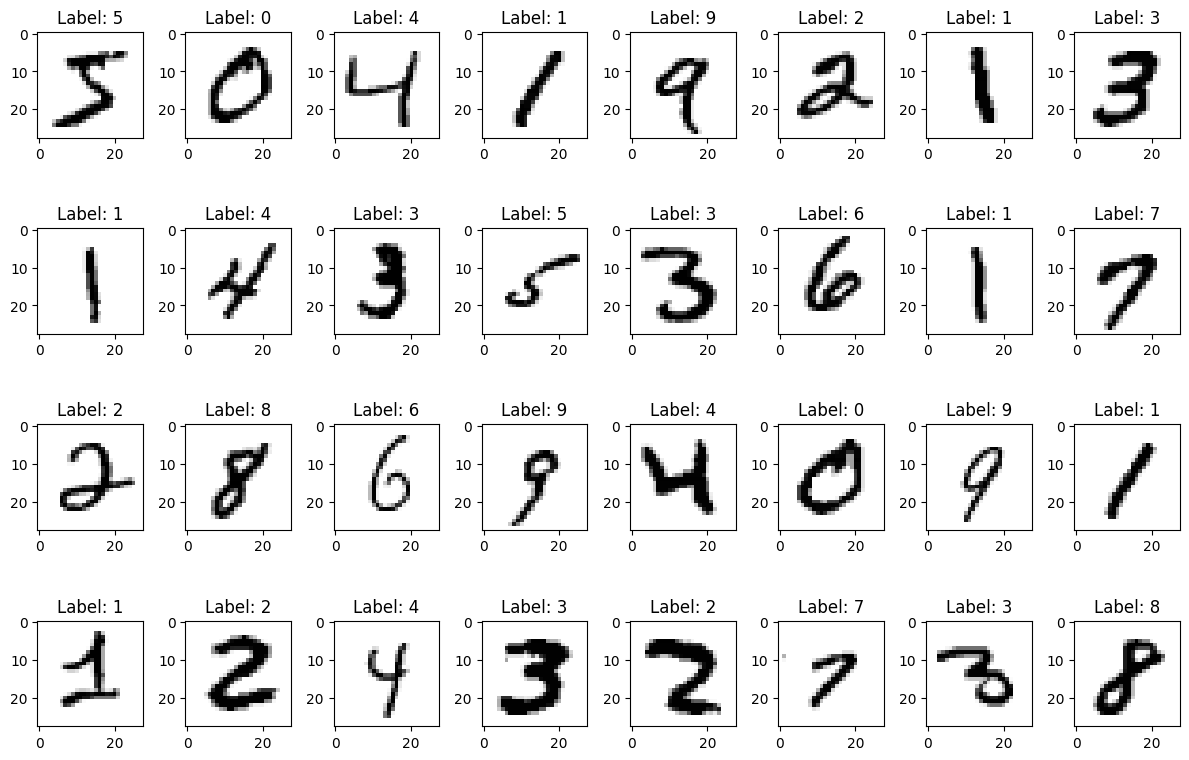

DESPUES:



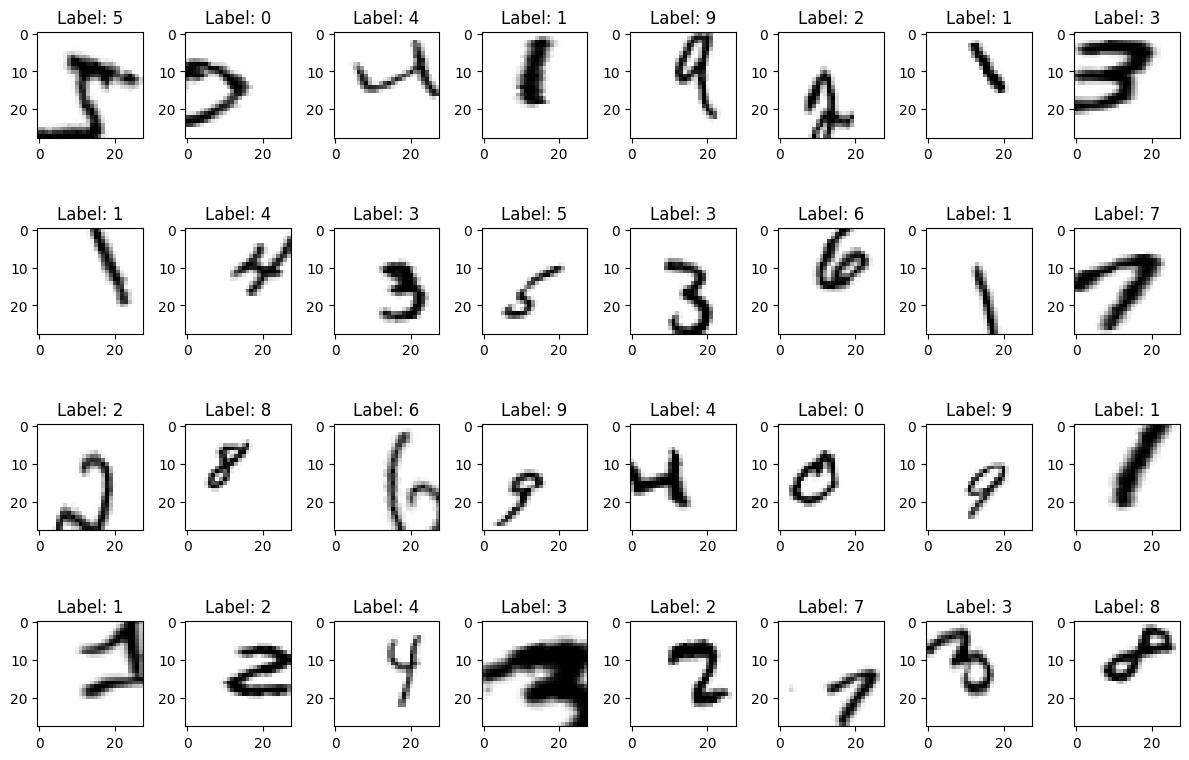

In [5]:
#Codigo para mostrar imagenes del set, no es necesario ejecutarlo, solo imprime como se ven antes y despues de las transformaciones
filas = 4
columnas = 8
num = filas*columnas
print('ANTES:\n')
fig1, axes1 = plt.subplots(filas, columnas, figsize=(1.5*columnas,2*filas))
for i in range(num):
     ax = axes1[i//columnas, i%columnas]
     ax.imshow(X_entrenamiento[i].reshape(28,28), cmap='gray_r')
     ax.set_title('Label: {}'.format(np.argmax(Y_entrenamiento[i])))
plt.tight_layout()
plt.show()
print('DESPUES:\n')
fig2, axes2 = plt.subplots(filas, columnas, figsize=(1.5*columnas,2*filas))
for X, Y in datagen.flow(X_entrenamiento,Y_entrenamiento.reshape(Y_entrenamiento.shape[0], 10),batch_size=num,shuffle=False):
     for i in range(0, num):
          ax = axes2[i//columnas, i%columnas]
          ax.imshow(X[i].reshape(28,28), cmap='gray_r')
          ax.set_title('Label: {}'.format(int(np.argmax(Y[i]))))
     break
plt.tight_layout()
plt.show()

### Creacion del modelo y compilacion

- Dropout

Se agrega en el entrenamiento del modelo, y funciona apagando de manera aleatoria un porcentaje de nodos durante el entrenamiento en cada paso de iteración. Esto obliga a la red neuronal a no depender excesivamente de ciertas neuronas, y evita el sobreajuste (overfitting).

Ejemplo: ``(tf.keras.layers.Dropout(0.5)`` Si se le da 0.5, durante el entrenamiento, en cada uno de los ciclos (epoch), los nodos tendrán un 50 % de probabilidad de desactivarse. Esto permite que las neuronas se pongan a trabajar, haciendo que la red sea más robusta.

In [6]:
#Crear el modelo 
#Cuenta con 1 capa de convolución con 32 núcleos y otra con 64 | 2 capas de agrupación.
#Finalmente una capa densa con 100 nodos
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'), # decimos el nº de nucleos y su tamaño: 32 núcleos de 3x3 / con input_shape decimos el tamaño de la imagen de entrada (28) y su nº de canales, que como estamos usando blanco y negro es 1
    tf.keras.layers.MaxPooling2D(2,2), #Capa de agrupación máxima, 2,2 es el tamano de la matriz

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 

    tf.keras.layers.Dropout(0.5), # Esta es la línea del DROPOUT
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compilación
modelo.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
#Los datos para entrenar saldran del datagen, de manera que sean generados con las transformaciones que indicamos
#Datagen es una instancia de ImageDataGenerator configurada con las transformaciones de Data Augmentation que definimos anteriormente
#El método flow toma los datos originales (X_entrenamiento y Y_entrenamiento) y los transforma en lotes según las transformaciones especificadas en datagen.
data_gen_entrenamiento = datagen.flow(X_entrenamiento, Y_entrenamiento, batch_size=32)

### Entrenamiento de la red neuronal

NOTA: Tarda un buen rato

In [8]:
TAMANO_LOTE = 32

print("Entrenando modelo...");
epocas=60
history = modelo.fit(
    data_gen_entrenamiento,
    epochs=epocas,
    batch_size=TAMANO_LOTE,
    validation_data=(X_pruebas, Y_pruebas),
    steps_per_epoch=int(np.ceil(60000 / float(TAMANO_LOTE))),
    validation_steps=int(np.ceil(10000 / float(TAMANO_LOTE)))
)

print("Modelo entrenado!");

Entrenando modelo...
Epoch 1/60


1875/1875 [==============================] - 117s 60ms/step - loss: 1.2240 - accuracy: 0.5878 - val_loss: 0.1925 - val_accuracy: 0.9513
Epoch 2/60
1875/1875 [==============================] - 106s 56ms/step - loss: 0.7214 - accuracy: 0.7669 - val_loss: 0.1200 - val_accuracy: 0.9646
Epoch 3/60
1875/1875 [==============================] - 99s 53ms/step - loss: 0.5985 - accuracy: 0.8087 - val_loss: 0.1060 - val_accuracy: 0.9689
Epoch 4/60
1875/1875 [==============================] - 101s 54ms/step - loss: 0.5472 - accuracy: 0.8217 - val_loss: 0.0834 - val_accuracy: 0.9741
Epoch 5/60
1875/1875 [==============================] - 94s 50ms/step - loss: 0.5048 - accuracy: 0.8364 - val_loss: 0.1170 - val_accuracy: 0.9645
Epoch 6/60
1875/1875 [==============================] - 65s 34ms/step - loss: 0.4803 - accuracy: 0.8454 - val_loss: 0.0866 - val_accuracy: 0.9719
Epoch 7/60
1875/1875 [==============================] - 59s 32ms/step - loss: 0.4547 - accuracy: 0

### Graficos

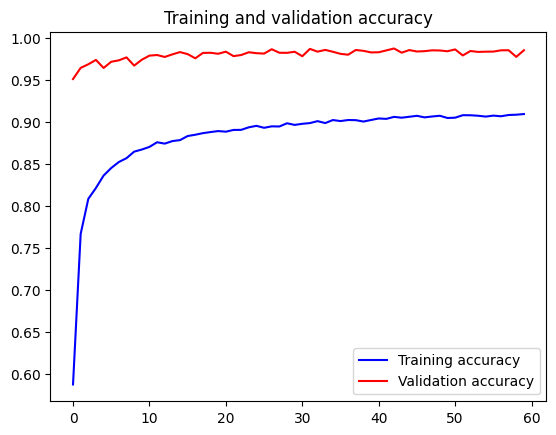

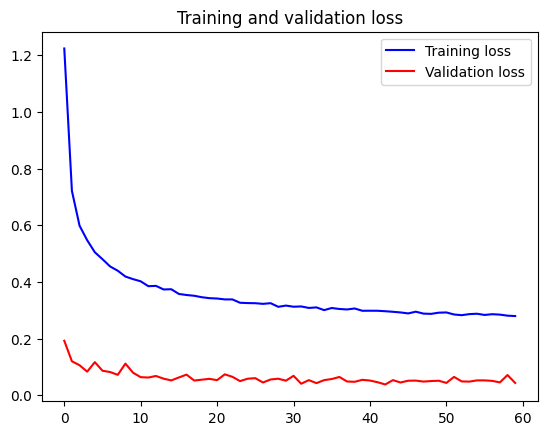

In [9]:
# grafica la funcion de perdida y el accuracy para el dataset de entrenamiento y validacion. 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

### Guardar modelo entrenado

In [12]:
# guardar modelo
modelo.save('../models/pred_numeros.h5')

c:\Users\kina5\Desktop\Bootcamp\mi_entorno\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
